In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
%matplotlib notebook

In [3]:
# small number is to be recognized as zero to avoid numerical problem (owning to the calculation accuracy)
tol_zero = 1e-10

1. define an optimization problem in the following form
$$
\begin{array}{rlr}
\min _{x} &  q(x)=\frac{1}{2} x^{T} G x+x^{T} c \\
\text { subject to } & a_{i} x=b_{i}, & i \in \mathcal{E} \\
& a_{i} x \geq b_{i}, & i \in \mathcal{I}
\end{array}
$$

In [4]:
def active_set(ai, bi, x0):
    '''
    Initialize the active set for the given initial state.
    Args:
        ai: Left-hand side of the inequality constraints (Ni x Nx).
        bi: right-hand side of the inequality constraints (Ni x 1).
        x0: initial state (Nx x 1).
        
    Return:
        active_set: rerturn the active set of the given inequality constraints at x0 (N_act x Nx).
        inactive_set: rerturn the inactive set of the given inequality constraints at x0 (N_inact x Nx).
    '''
    n_active_row = (ai @ x0 - bi == 0).flatten()
    n_inactive_row = ~ n_active_row
    active_set = np.hstack((ai[n_active_row],bi[n_active_row]))
    inactive_set = np.hstack((ai[n_inactive_row],bi[n_inactive_row]))
    active_pos = np.ravel(np.where(n_active_row))
    inactive_pos = np.ravel(np.where(n_inactive_row))
    return active_set,inactive_set, active_pos, inactive_pos

In [5]:
def QP_subproblem(G, c, ws, xk):
    
    '''
    Solve the QP subproblem for Newton-KKT system.
    Args:
        G: Weigting matrix of quadratic terms (Nx x Nx).
        c: Weigting matrix of linear terms (Nx x 1).
        ws: working space ( (Ne + N_active) x (Nx + 1)).
        xk: Curret state (Nx x 1).
        
    Return:
        pk: search step (Nx x 1). 
        lambda_k: Lagrangian multiplier ( (Ne + N_active) x 1
    '''
    
    
    Nx = np.shape(xk)[0]
    Nlambda = np.shape(ws)[0]
    
    A = ws[:,0:-1]
    
    gk = G @ xk + c
    rhs = np.vstack((-gk,np.zeros([Nlambda,1])))
    lhs = np.vstack((np.hstack((G,-A.T)),np.hstack((A,np.zeros([Nlambda,Nlambda])))))
    sol = np.linalg.inv(lhs) @ rhs
    sol[abs(sol) < tol_zero] = 0.0
    return sol[:Nx,:],sol[Nx:,:]

In [6]:
def QP_activeset(G, c, ae = None, be = None, ai= None, bi= None, x0 = None):
    '''
    Solve the convex QP problem with active-set method
    Args:
        G: Weigting matrix of quadratic terms (Nx x Nx).
        c: Weigting matrix of linear terms (Nx x 1).
        ae: Left-hand side of the equality constraints (Ne x Nx).
        be: Right-hand side of the equality constraints  (Ne x 1).
        ai: Left-hand side of the inequality constraints (Ni x Nx).
        bi: Right-hand side of the inequality constraints (Ni x 1).        
        x0: Initial state (Nx x 1).    
    
    Returns: 
        xk: Optimial state.
    
    TODO:
        1. deal with infeasible initial point.
        2. Select another algorithm for the QP subproblem.
        3. Tranform into C code.
        4. Visualization.
        5. Find a better way to deal with the empty set.
        6. If G is singular, cannot use the inverse function. -> use Newton-Raphson method instead.
    '''
    xk_plot =[]
    active_set_plot = []
    
    
    # Test if the given initial point is feasible.
    Nx = np.shape(G)[0]
    if x0 is None:
        x0 = np.zeros(Nx).reshape(-1,1)
    if ae is not None:
        if not np.all(ae @ x0 - be == 0):
            print("Error")
            return None
    if ai is not None:
        if not np.all(ai @ x0 - bi >= 0):
            print("Error")
            return None
    xk = x0
    
    xk_plot.append(xk)    #  append state position for the plot purpose
    #initialization.
    if ae is not None:
        Ne = np.shape(ae)[0]
    else:
        Ne = 0
    if ai is not None:
        Ni = np.shape(ai)[0]
        # Return which set is active. Empty array if none inequality constraint is active.
        ws_active, ws_inactive, active_pos, inactive_pos = active_set(ai, bi, xk)
    else:
        Ni = 0 
        ws_active = np.array([], dtype=np.int).reshape(0,Nx+1)
        ws_inactive = np.array([], dtype=np.int).reshape(0,Nx+1)

    if ae is None:
        we = np.array([], dtype=np.int).reshape(0,Nx+1)
    else:
        we = np.hstack((ae,be))

    active_set_plot.append(active_pos)    #  append active set for the plot purpose
    # Define working space = equality constraints + active inequality constraints.
    ws = np.vstack((we,ws_active))
    
    
    while(True):
        # Solve QP subproblem.
        pk,lambda_k = QP_subproblem(G,c,ws,xk)
        # Seperate the Lagrangian multiplier into two parts for equality constraints and inequality constraints. 
        if np.shape(lambda_k)[0] > Ne:
            lambda_inequality = lambda_k[Ne:,:]
        else:
            lambda_inequality = np.array([], dtype=np.int).reshape(0,1)
        n_zero = Nx - np.count_nonzero(pk)
        # If search step vector has only element with 0 value. 
        if n_zero == Nx:
            # p statisfies the optimality conditions, check the signs of the multipliers.
            if np.all(lambda_inequality >= 0):
                print("solution find")
                return xk, lambda_k, xk_plot, active_set_plot
            else:
                # Droping the working constraint with most negative value.
                n_min = np.argmin(lambda_inequality)
                row_del = ws_active[n_min,:]
                ws_active = np.delete(ws_active, (n_min), axis=0)
                
                pos_del = active_pos[n_min]
                active_pos = np.delete(active_pos, (n_min), axis=0) 
                inactive_pos = np.append(inactive_pos,pos_del)
                active_set_plot.append(active_pos)    #  append active set for the plot purpose

                ws_inactive = np.vstack((ws_inactive, row_del))
#                 inactive_pos.
                ws = np.vstack((we,ws_active))
        # p vector not zero -> calculate the search length alpha.
        else:
            # Yield alpha value.
            alpha_k = 1
            for i,row in enumerate(ws_inactive):
                b = row[-1]
                a = row[:-1]
                if (a @ pk)[0] < 0:
                    v_tmp = (( b - a @ xk )/ (a @ pk))[0]
                    if v_tmp < 1:
                        n_constraint = i
                        alpha_k = v_tmp
            if alpha_k == 1:
                xk = xk + pk * alpha_k
                xk_plot.append(xk)    #  append state position                
            # If not a full step, include the most restrive inactive constraint into working space.
            else:
                row_inc = ws_inactive[n_constraint,:]
                ws_active = np.vstack( (ws_active, row_inc))
                
                pos_add = inactive_pos[n_constraint]
                print(active_pos)
                active_pos = np.append(active_pos, pos_add)
                inactive_pos = np.delete(inactive_pos, (n_constraint), axis=0) 
                active_set_plot.append(active_pos)    #  append active set for the plot purpose
                
                
                ws_inactive = np.delete(ws_inactive, (n_constraint), axis=0)
                ws = np.vstack((we,ws_active))
                xk = xk + pk * alpha_k
                xk_plot.append(xk)    #  append state position

### Test1: 
$$
\begin{aligned}
\min _{x} q(x)  =\left(x_{1}-1\right)^{2}+&\left(x_{2}-2.5\right)^{2}\\
\text { subject to }  x_{1}-2 x_{2}+2 & \geq 0 \\
-x_{1}-2 x_{2}+6 & \geq 0 \\
-x_{1}+2 x_{2}+2 & \geq 0 \\
x_{1} & \geq 0 \\
x_{2} & \geq 0
\end{aligned}
$$

In [7]:
# QP problem
ai = np.array([[1,-2],[-1,-2],[-1,2],[1,0],[0,1]],dtype = np.float32)
bi = np.array([-2,-6,-2,0,0],dtype = np.float32).reshape(-1,1)
G = np.diag([2,2])
c = np.array([-2,-5]).reshape(-1,1)

In [8]:
xk, lambda_k, xk_plot, active_set_plot = QP_activeset(G,c,ai=ai,bi=bi,x0 = np.array([[2],[0]]))
xk, lambda_k, xk_plot, active_set_plot

[]
solution find


(array([[1.4],
        [1.7]]),
 array([[0.8]]),
 [array([[2],
         [0]]),
  array([[1.],
         [0.]]),
  array([[1. ],
         [1.5]]),
  array([[1.4],
         [1.7]])],
 [array([2, 4]), array([4]), array([], dtype=int64), array([0])])

In [9]:
# xk, lambda_k, xk_plot, active_set_plot = QP_activeset(G,c,ai=ai,bi=bi,x0 = np.array([[4],[1]]))
# xk, lambda_k, xk_plot, active_set_plot

### Plot

In [10]:
test_point = np.array([1e10,1e10]).reshape(-1,1)

In [11]:
def cost_for(x1, x2, z, f):
    Nx_p = np.shape(x1)[1]
    x_plot = np.vstack((x1,x2))
    print(np.shape(z))
    for i in range(Nx_p):
        z[:,i] = f(x_plot[:,i])

In [12]:
def plot_init(G, c, x1_range = None, x2_range = None, z_range = None):
    if x1_range is None:
        x1_val  = np.arange(-1, 4, 0.1, dtype=np.float32)
    else:
        x1_val = x1_range
    if x2_range is None:
        x2_val = np.arange(-1, 4, 0.1, dtype=np.float32)
    else:
        x2_range = x2_val
    x1_val_mesh, x2_val_mesh = np.meshgrid(x1_val, x2_val)
    x1_val_mesh_flat = x1_val_mesh.reshape([1, -1])
    x2_val_mesh_flat = x2_val_mesh.reshape([1, -1])

    z_val_mesh_flat = np.zeros_like(x1_val_mesh_flat)
    f = lambda x: x.T @ G @ x + x.T @ c
    cost_for(x1_val_mesh_flat,x2_val_mesh_flat,z_val_mesh_flat,f)

    # z_val_mesh = np.reshape([(lambda x1,x2: (x1-1)**2 + (x2-2.5)**2)(x1,x2) for x1,x2 in zip(x1_val_mesh_flat,x2_val_mesh_flat)],(x1_val_mesh.shape))
    z_val_mesh = np.reshape(z_val_mesh_flat,(x1_val_mesh.shape))

    
    fig = plt.figure(figsize=(6, 4))
    spec=fig.add_gridspec(nrows=1,ncols=1)
    ax1 = fig.add_subplot(spec[0,0],projection='3d' )
    ax1.plot_surface(x1_val_mesh, x2_val_mesh, z_val_mesh, alpha=0.5, cmap=cm.coolwarm)

    # ax1.set_xlim(0, 1)
    # ax1.set_ylim(0, 1)
    ax1.set_zlim(0, 40)

    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('Z')
    return ax1

In [13]:
def plot_constraints(ax, ai, bi, x1_range = None, x2_range = None):
    Ni = np.shape(ai)[0]
    i_state = []
    if x1_range is None:
        x1_val  = np.arange(-1, 4, 0.1, dtype=np.float32)
    else:
        x1_val = x1_range
#     if x2_range is None:
#         x2_val = np.arange(-5, 5, 0.1, dtype=np.float32)
#     else:
#         x2_range = x2_val
    N_x1 = np.shape(x1_val)[0]
    x2_array = np.array([], dtype=np.float32).reshape(0,N_x1)

    for i in range(Ni):
        if ai[i,1] != 0:
            x2_val = ((bi[i,0] - ai[i,0] * x1_val) / ai[i,1] ).reshape(1,-1)
            x2_array = np.vstack((x2_array,x2_val))
        else:
            x2_val =  np.full_like(x1_val, np.NaN)
            x2_array = np.vstack((x2_array,x2_val))
    
    for i in range(Ni):
        if ai[i,1] != 0:
            ax1.plot(x1_val, x2_array[i,:], zs=0, zdir='z',color = 'k')
        else:
            x2_val = np.arange(-1, 4, 0.1, dtype=np.float32)    #  To be modified
            x1_straight = np.full_like(x1_val,bi[i,0])
            ax1.plot(x1_straight, x2_val, zs=0, zdir='z',color = 'k')
            
    for i in range(Ni):        
        if ai[i,:].reshape(1,-1) @ test_point - bi[i,0] >= 0:
            if ai[i,1] == 0:
                i_state.append("left_b")
                x1_bound = bi[i,0]
            else:
                i_state.append("lb")
        else:
            if ai[i,1] == 0:
                i_state.append("right_b")
                x1_bound = bi[i,0]
            else:
                i_state.append("ub")

    ub_array = np.array([], dtype=np.float32).reshape(0,N_x1)
    lb_array = np.array([], dtype=np.float32).reshape(0,N_x1)
    left_b = np.NaN
    rigit_b = np.NaN
    for i in range(Ni):
        if i_state[i] == "lb":
            lb_array = np.vstack((lb_array,x2_array[i,:].reshape(1,-1)))
        elif i_state[i] == "ub":
            ub_array = np.vstack((ub_array,x2_array[i,:].reshape(1,-1)))
        elif i_state[i] == "left_b":
            left_b = bi[i,0]
        else:
            rigit_b = bi[i,0]

    lb = np.max(lb_array,axis = 0)
    ub = np.min(ub_array,axis = 0)

    bound_pos = np.ravel( np.where(lb < ub))
    left_pos = bound_pos[0]
    right_pos = bound_pos[-1]

    x1_left = x1_val[left_pos]
    x1_right = x1_val[right_pos]

    if left_b != np.NaN  and (left_b > x1_left):
        left_pos = np.ravel(np.where(x1_val >= left_b))[0]
    if rigit_b != np.NaN  and (rigit_b < x1_right):
        right_pos = np.ravel(np.where(x1_val <= right_b))[-1]
    
    ax1.add_collection3d(plt.fill_between(x1_val[left_pos:right_pos], lb[left_pos:right_pos], ub[left_pos:right_pos], color='grey',alpha = 0.3) ,zdir='z')

               

    return x1_val, x2_array

In [14]:
def update_plot(f,ax, ai, bi, x1_val,x2_array,xk_plot, active_set_plot):

    Ni = np.shape(ai)[0]    
    N_plot = np.shape(xk_plot)[0]
    constraint_i = np.hstack((ai,bi))
    
    plot_cache = None
    for n_plot in range(N_plot):
        xk = xk_plot[n_plot]
        print(xk)
        active_set = active_set_plot[n_plot]
        N_active =  np.shape(active_set)[0]
        if n_plot == 0:
            f_value = f(xk)
            plot_cache = ax.scatter(xk[0], xk[1], f_value, s=20, depthshade=True, color='r')
            x_past = xk
            f_past = f_value
        else:
            f_value = f(xk)
            plot_cache.remove()
            plot_cache = ax.scatter(xk[0], xk[1], f_value, s=20, depthshade=True, color='r')

            ax.plot([x_past[0,0], xk[0,0]], [x_past[1,0], xk[1,0]], [f_past[0,0], f_value[0,0]], linewidth=2, color='r')

            x_past = xk
            f_past = f_value            
        
        for i in range(Ni):
            if i in active_set:
                if ai[i,1] != 0:
                    ax1.plot(x1_val, x2_array[i,:], zs=0, zdir='z',color = 'r')
                else:
                    x2_val = np.arange(-1, 4, 0.1, dtype=np.float32)    #  To be modified
                    x1_straight = np.full_like(x1_val,bi[i,0])
                    ax1.plot(x1_straight, x2_val, zs=0, zdir='z',color = 'r')
            else:
                if ai[i,1] != 0:
                    ax1.plot(x1_val, x2_array[i,:], zs=0, zdir='z',color = 'k')
                else:
                    x2_val = np.arange(-1, 4, 0.1, dtype=np.float32)    #  To be modified
                    x1_straight = np.full_like(x1_val,bi[i,0])
                    ax1.plot(x1_straight, x2_val, zs=0, zdir='z',color = 'k')

                
        plt.savefig('./active_set/test1_' + str(n_plot) + '.png')

(1, 2500)


<IPython.core.display.Javascript object>


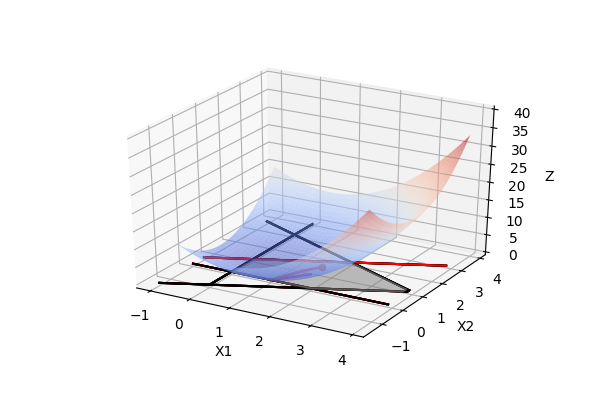

In [15]:
ax1 = plot_init(G,c)


In [16]:
x1_val, x2_array =plot_constraints(ax1, ai,bi)

In [17]:
xk = xk_plot[0]
print(xk)

[[2]
 [0]]


In [18]:
# xk_plot
# active_set_plot


f = lambda x: x.T @ G @ x + x.T @ c

update_plot(f, ax1,ai,bi,x1_val,x2_array,xk_plot,active_set_plot)

[[2]
 [0]]
[[1.]
 [0.]]
[[1. ]
 [1.5]]
[[1.4]
 [1.7]]


In [20]:
import imageio

images = []
filenames = ['./active_set/test1_' + str(i) + '.png' for i in range(4)]

imageio.plugins.freeimage.download()

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./active_set/movie.gif', images, format='GIF-FI', duration=0.001)

In [ ]:
![](191px-Seven_segment_display-animated.gif "segment")